In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay
import sklearn.gaussian_process.kernels as k
from scipy.interpolate import interp1d
from tqdm import tqdm
from astroML.utils import split_samples
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
pip install pyarrow

  Using cached pyarrow-16.1.0-cp39-cp39-manylinux_2_28_x86_64.whl (40.8 MB)
Note: you may need to restart the kernel to use updated packages.


# Description of Layout and Processes

This notebook is organized as following: For each dataset _Single Lightcurves_, _Stacked Lightcurves_, _Poorly Sampled Lightcurves_, and _Plasticc Lightcurves_ we perform an analysis using Gaussian Processes, A Simple Neural Network, and a Recurrent Neural Network.

Each dataset contains each of the three processing methods, with all the analysis functions for each method contained within the 'Analysis Functions' section. Below, we describe the background and motivation for each of the three processes. For interesting cases, we provide further explanation directly above the processing method results. In order to perform predictions and analysis for each of the datasets, we remove the last 10 points from each lightcurve, and use perform a prediction of those same 10 points. We evaluate the accuracy of our network by comparing the fit points (10 points as an output of the network) to the 10 true data points that were removed. The performance of our network is evaluated based on this comparison.

### Gaussian Process

The gaussian process (GP) method is described in the same way as sampling a gaussian function and finding the mean and standard deviation of a dataset. In this case, the information that is being sampled are functions. That is, instead of something where $N(\mu, \sigma)$, where the $\mu$ and $\sigma$ are values that can be fit to, we have $N[f(\mu(x)), f(\sigma(x)]$ and are trying to fit to functions that describe the set of data $x$. Gaussian processes work very well for a single dataset that is sampled well and relatively simple. For unpredictable data, or data that requires averaging over many samples (a strength of NNs), GP becomes very ineffective. In the case of astronomical data, more robust ML algorithms become necessary, which we explore below for Simple Neural Networks and Recurrent Neural Networks.

### Simple Neural Network

For this prediction method, we use keras.sequential neural network which deals with ordering or sequencing of layers within a model. As we are dealing with time series data, this felt like a good choice. The four datasets that we used are a finely sampled sine curve, a multifrequency finely sampled dataset, a poorly sampled multifrequency dataset, and realistic data from the PLAsTiCC astronomical dataset. Since my neural network requires the data shapes to be same, I interpolated the data and sampled it on a finer grid before feeding it into the neural network. Since the data is not linear, instead of using a linear interpolator, I used a cubic spline- doing this made the prediction for the 3rd dataset which is sparsely sampled multifrequency sine curve significantly better. I used 2-3 hidden layers depending on the dataset and got small values for mse, and my network converged. However, for the fourth dataset, I could not get my nn to converge, I tried to sample differently, but didn't get much of an improvement. The neural network doesn't learn any pattern from the data so the learning rate after trying for a few epochs, stays the same. I have tried predicting 10 next points, 3 next points or just one point. The mse doesn't show much of an improvement on any of the cases.

### Recurrent Neural Network

A recurrent neural network (RNN) works by continuously updating its fitting function with each additional datapoint. The RNN takes an input data and a *cell* and uses those two to produce an output and an updated cell. This new cell is then combined with the next piece of data in the system and repeats the process. That is, at every data (time) step, the cell used for performing a fit is updated, and an output is identified. That way, in order to add more data to the fit, one has to combine the data with the output and the final cell.

The recurrent neural network was chosen for its exceptional ability to analysze sequential data. Since these lightcurves are partially sampled, and have time-oriented data, RNNs work very well.

### Analysis Functions

In [3]:
def plot_timeseries(df: pd.DataFrame, indx=0 ) -> None:
    '''Plot the generated time series data.
        Args:
            df: Pandas DataFrame with the generated data
            indx: index of the time series to plot
        '''
    df[f'y{indx}' ].plot(style='o')  

    plt.show()

In [4]:
def plottingFits(x, y, x_pred, y_pred, x_model, y_model, sigma, fit_unc):
    '''
    Plots the uncertainty range for the Gaussian Process Fitting
    ---------------------
    x (array)       : x data
    y (array)       : y data
    x_model (array) : x data fit to the model
    y_model (array) : y model output by the model (for x data)
    sigma (array)   : Uncertaintiy at each point
    fit_unc (array) : Uncertaintiy at each point
    ---------------------
    returns (figure)
    '''
    
    plt.figure(figsize=(10, 5))
    plt.scatter(x, y, label='True Data')
    plt.plot(x_model, y_model, c='r', label = 'GP Fit')
    plt.scatter(x_pred, y_pred, c='r', label='Prediction with GP')
    plt.fill_between(
        x_model,
        y_model - (1.96 * fit_unc),
        y_model + (1.96 * fit_unc),
        alpha=0.3,
        label="95% confidence interval(GP)"
    )
    plt.xlabel('$Days$')
    plt.ylabel('$Flux$')
    plt.legend(loc = 'lower left')
    #plt.savefig('plasticcLC_2.png', dpi=300)
    return(plt.show())

In [5]:
def data_read_full(data_type):
    '''
    Reads in the data for all the lightcurves and outputs both the time and flux values in the correct format 
    ---------------------
    data_type (string) : Data identifier to read in the corresponding data. Can choose from ('plasticc_test', 'single', 'multiple', 'multiple_sampled')
    ---------------------
    returns (tSeries, intensity_data) : (list of lists, list of lists) time and corresponding flux values at each element in the array 
    '''
    
    if(data_type == 'plasticc_test'):
        lcs = []
        plasticc_metadata = pd.read_pickle('Project data/plasticc_lightcurves_g_metadata.pkl')
        with open('Project data/plasticc_lightcurves_g.pkl', 'rb') as file:
            plasticc_LC = pickle.load(file)

        y_true = plasticc_metadata['target'].iloc[:].values

        for i in tqdm(range(len(plasticc_metadata))):
            try:
                lc = (np.array([(plasticc_LC[plasticc_metadata['object_id'].iloc[i]].index).values, plasticc_LC[plasticc_metadata['object_id'].iloc[i]].values]).T).tolist()
                lcs.append(lc)
            except KeyError:
                continue
        return(lcs, y_true)
    
    else:
        if (data_type == 'single'):
            df = pd.read_feather("Project data/timeseries_single_frequency.feather")
            
        elif (data_type == 'multiple'):
            df = pd.read_feather("Project data/timeseries_multiple_frequency.feather")

        elif (data_type == 'multiple_sampled'):
            df = pd.read_feather("Project data/timeseries_multiple_frequency_sampled.feather")
        
        tSeries = df.index.values
        intensity_data = df.values
    
        return(tSeries, intensity_data)

In [6]:
def data_read_image(data_type, image_number = 20):
    '''
    Reads in the data for a single lightcurve and outputs both the time and flux values in the correct format
    ---------------------
    data_type (string) : Data identifier to read in the corresponding data. Can choose from ('plasticc_test', 'single', 'multiple', 'multiple_sampled')
    ---------------------
    returns (list, list) : time and corresponding flux values 
    '''
    if (data_type == 'plasticc'):
        
        plasticc_metadata = pd.read_pickle('Project data/plasticc_lightcurves_g_metadata.pkl')
        with open('Project data/plasticc_lightcurves_g.pkl', 'rb') as file:
            plasticc_LC = pickle.load(file)

        tSeries = plasticc_LC[plasticc_metadata['object_id'].iloc[image_number]].index.values
        intensity_data = plasticc_LC[plasticc_metadata['object_id'].iloc[image_number]].values
        y_true = plasticc_metadata['true_target'].iloc[image_number]
        return(np.array(tSeries), intensity_data, y_true)
    
    else:
        if (data_type == 'single'):
            df = pd.read_feather("Project data/timeseries_single_frequency.feather")

        elif (data_type == 'multiple'):
            df = pd.read_feather("Project data/timeseries_multiple_frequency.feather")

        elif (data_type == 'multiple_sampled'):
            df = pd.read_feather("Project data/timeseries_multiple_frequency_sampled.feather")
    
        tSeries = df['y50']
        time_range = tSeries.axes[0].tolist()
        intensity_data = tSeries.values
    
        return(np.array(time_range), intensity_data)

In [7]:
def pointPrediction(new_fit, n_pred, x, y):
    '''
    For the single and multiple fitting, identifies the next 10 points to predict based on the time steps given in the raw data and uses GP to fit to that data
    ---------------------
    new_fit (function) : gaussian process regresser (after performing a fit)
    n_pred (float)     : number of points to predict
    x (array)          : time values from data
    y (array)          : flux values from data
    ---------------------
    return (array, array) : Number of predicted x (time) values, predicted y values based on the best fit gaussian process
    '''
    
    delta_t = x[-1] - x[-2]
    x_pred = (np.array([range(1, 1 + n_pred)]).T)*delta_t + x[-1]
    
    return(x_pred, *new_fit.predict(x_pred, return_std = True))

In [8]:
def gaussianProcess_fitting(x, y, kernel, n_pred):
    '''
    Wrapper function holding the gaussian process function
    ---------------------
    x (function)   : time values from data
    y (float)      : flux values from data
    kernel (array) : kernel function for GP to fit to 
    n_pred (array) : number of points to predict
    ---------------------
    return (array, array, array, function, array, array, array) : corresponding x and y predictions w/ uncertainties, parameters from model fitting,
    x and y model fit and their uncertainties
    '''
    
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=90)
    gp.fit(x, y)
    optimizedParams = gp.kernel_
    
    x_pred, y_pred, sigma = pointPrediction(gp, n_pred, x, y)
    
    x_model = np.linspace(min(x), max(x_pred), 100)
    y_model, fit_unc = gp.predict(x_model, return_std=True)
    
    return(x_pred, y_pred, sigma, optimizedParams, x_model, y_model, fit_unc)

In [9]:
def sampled_interp(x, y):
    '''
    Interpolation function for simple poorly sampled lightcurves
    ---------------------
    x (list of lists) : time values from data
    y (list of lists) : flux values from data
    ---------------------
    returns (list of lists) : Interpolated light curves for each of the y lightcurves
    '''
    
    lc_sample = np.zeros_like(y.T)
    for i, lc in enumerate(y.T):
        x_new = x[~np.isnan(lc)]
        lc_new = lc[~np.isnan(lc)]

        spl = interp1d(x_new, lc_new, kind='cubic', fill_value= 'extrapolate')
        time_range = np.linspace(min(x_new), max(x_new), 50)
        lc_sample[i] = spl(time_range)
    return(lc_sample)

In [10]:
def Simple_NN(lc_x, y_cat):
    
    (X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(lc_x, y_cat, [0.8, 0.1, 0.1], random_state=0)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X_train)

    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_root_mean_squared_error",
            factor=0.1,
            patience=5,
            verbose=1,
            min_delta=0.0001,
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_root_mean_squared_error",
            min_delta=1e-6,
            patience=10,
            verbose=1,
        )
    ]
    model = keras.Sequential([
        normalizer,
        layers.Dense(4, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(10, activation='linear') 
    ])

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.RootMeanSquaredError()]
    )

    history = model.fit(
        X_train, 
        y_train,
        batch_size=128,
        epochs=200,
        validation_data=(tf.convert_to_tensor(X_test), tf.convert_to_tensor(y_test)),
        callbacks=callbacks
    )
    pred_proba = model.predict(X_test)
    return(X_test, pred_proba, y_test)

In [11]:
def RNN_fitting(lc_x, y_cat, n_pred):
    '''
    Wrapper function holding the Recurrent Neural Network
    ---------------------
    lc_x (list of lists)  : First (k) points in each lightcurve to act as a the training data
    y_cat (list of lists) : Last (n) points in each light curve for the lightcurve to fit to
    n_pred (float)        : number of points to predict
    ---------------------
    returns (array, array, array) : Testing data, output of the RNN fitting to test data, true values of RNN fitting
    '''
    
    #normalizer = layers.Normalization()
    #normalizer.adapt(lc_x)
    
    (X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(lc_x, y_cat, [0.8, 0.1, 0.1], random_state=0)

    
    print(np.shape(X_train))
    
    model = keras.Sequential([
    layers.Input(np.shape(X_train[0].reshape(-1,1))),
    layers.GRU(32, return_sequences=True),
    layers.GRU(16, return_sequences=True),
    layers.GRU(16, return_sequences=True),
    layers.GRU(14),
    layers.Dense(n_pred, activation='linear')
    ])

    model.summary()

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.RootMeanSquaredError()]
    )

    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=5,
            verbose=1,
            min_delta=1e-4,
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-4,
            patience=10,
            verbose=1,
        )
    ]

    history = model.fit(X_train,
        y_train,
        batch_size=128,
        epochs=100,
        validation_data=(X_valid, y_valid),
        callbacks=callbacks
    )

    pred_proba = model.predict(X_test)
    return(X_test, pred_proba, y_test)

In [12]:
def lf_processing_Plasticc(lcs):
    '''
    Interpolation function for plasticc dataset
    ---------------------
    x (list of lists) : time values from data
    y (list of lists) : flux values from data
    ---------------------
    returns (list of lists), (list of lists) : Interpolated light curves for each of the y lightcurves, time associated with that lightcurve
    '''
    
    time_sample = np.zeros((len(lcs), 50))
    lc_sample = np.zeros((len(lcs), 50))

    for i, lc in enumerate(lcs):
        lc = np.asarray(lc)
        lc_timing = lc[:,0]
        lc_flux = lc[:,1]
        spl = interp1d(lc_timing, lc_flux, kind='cubic', fill_value= 'extrapolate')
        time_range = np.linspace(min(lc_timing), max(lc_timing), 50)
        processed_lc = spl(time_range)
        time_sample[i] = time_range
        lc_sample[i] = processed_lc
        
    return(lc_sample, time_sample)

In [13]:
def plasticc_normalizer(lcs):
    '''
    Normalizes the lightcurves from the plasticc dataset
    -------------------
    lcs (list of lists) : Lightcurves from plasticc data, but only the flux values
    -------------------
    returns (list of lists) : Normalized lightcurves from 0 to 1
    '''
    lc_normalized = np.zeros_like(lcs)
    for i, lc in enumerate(lcs):
        lc_normalized[i] = preprocessing.normalize([lc])
    return(lc_normalized)

# Single Lightcurve Fitting

The single lightcurves are straightforward, and are composed of 10000 lightcurves with 50 datapoints each. The periods are fixed for each lightcurve, and so make analysis very straightfoward. We expect fitting for all networks to work best for this data type, and we see that as the case.

#### Gaussian Process

/opt/conda/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Optimized hyper parameters:  6.38**2 * RBF(length_scale=22.1)


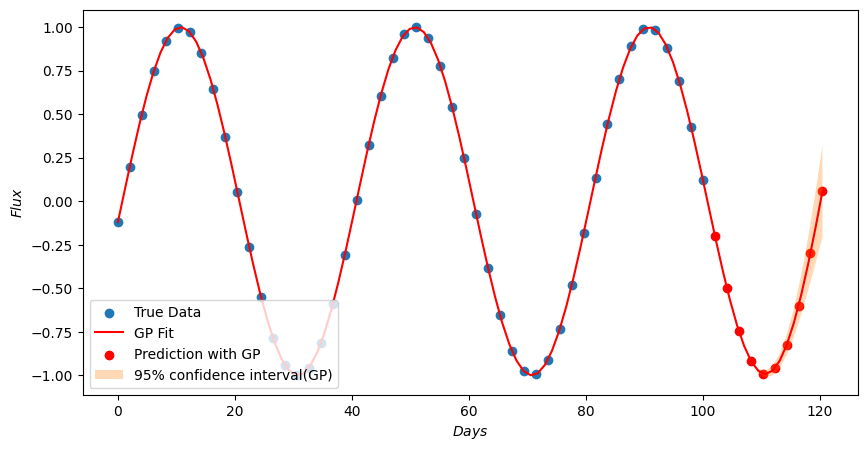

In [14]:
x, y = data_read_image('single')
x_true = x
x = x.reshape(-1,1)
n_points = 10

kernel = np.var(y) * k.RBF(length_scale=10.0)


x_pred, y_pred, sigma, optimizedParameters, x_model, y_model, fit_unc = gaussianProcess_fitting(x, y, kernel, n_pred = n_points)
print("Optimized hyper parameters: ", optimizedParameters)

plottingFits(x, y, x_pred, y_pred, x_model.flatten(), y_model.flatten(), sigma, fit_unc)

#### Simple Neural Network

In [15]:
x, y = data_read_full('single')

n_pred = 10
y_test_single = y[:-n_pred,:].T[0:2000]
y_fit_single = y[-n_pred:,:].T[0:2000]

SNN_X_single, SNN_Y_single, Simple_y_test_single = Simple_NN(y_test_single, y_fit_single)

2024-06-03 19:54:22.192972: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
13/13 [==============================] - 1s 14ms/step - loss: 0.6183 - root_mean_squared_error: 0.7863 - val_loss: 0.5174 - val_root_mean_squared_error: 0.7193 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 0s 3ms/step - loss: 0.4900 - root_mean_squared_error: 0.7000 - val_loss: 0.4516 - val_root_mean_squared_error: 0.6720 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 0s 5ms/step - loss: 0.4236 - root_mean_squared_error: 0.6508 - val_loss: 0.4053 - val_root_mean_squared_error: 0.6366 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 0s 3ms/step - loss: 0.3766 - root_mean_squared_error: 0.6136 - val_loss: 0.3689 - val_root_mean_squared_error: 0.6074 - lr: 0.0010
Epoch 5/200
13/13 [==============================] - 0s 4ms/step - loss: 0.3407 - root_mean_squared_error: 0.5837 - val_loss: 0.3369 - val_root_mean_squared_error: 0.5804 - lr: 0.0010
Epoch 6/200
13/13 [==============================] - 0s 3ms/step - loss: 0.3080

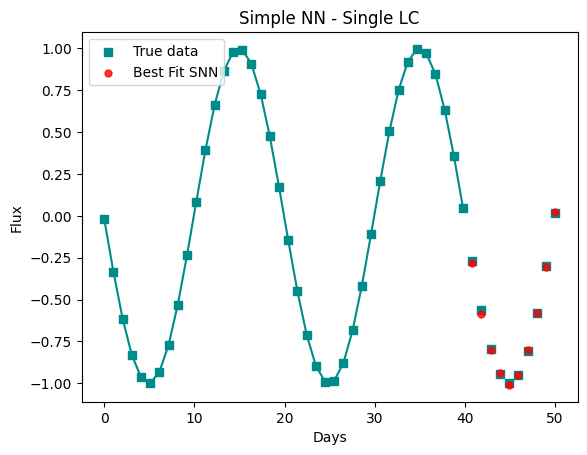

In [16]:
test_image = 2

t_space = np.linspace(0, 50, 50)
plt.plot(t_space[:-n_pred], SNN_X_single[test_image], color ='darkcyan')
plt.scatter(t_space[:-n_pred], SNN_X_single[test_image], color = 'darkcyan', marker='s')
plt.scatter(t_space[-n_pred:], Simple_y_test_single[test_image], color = 'darkcyan', marker='s', label = 'True data')
plt.scatter(t_space[-n_pred:], SNN_Y_single[test_image], color = 'red', marker = 'o', s=25, label = 'Best Fit SNN', alpha = 0.8)
plt.title('Simple NN - Single LC')
plt.xlabel('Days')
plt.ylabel('Flux')
plt.legend(loc = 'upper left')
#plt.savefig('RNN_Single.png', dpi=300)

#### Recurrent Neural Network

In [17]:
x, y = data_read_full('single')

n_pred = 10
y_test_single = y[:-n_pred,:].T[0:2000]
y_fit_single = y[-n_pred:,:].T[0:2000]

RNN_X_single, RNN_Y_single, y_test_single = RNN_fitting(y_test_single, y_fit_single, n_pred)

(1600, 40)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 40, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 40, 16)            2400      
                                                                 
 gru_2 (GRU)                 (None, 40, 16)            1632      
                                                                 
 gru_3 (GRU)                 (None, 14)                1344      
                                                                 
 dense_3 (Dense)             (None, 10)                150       
                                                                 
Total params: 8,886
Trainable params: 8,886
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
13/13 [======================

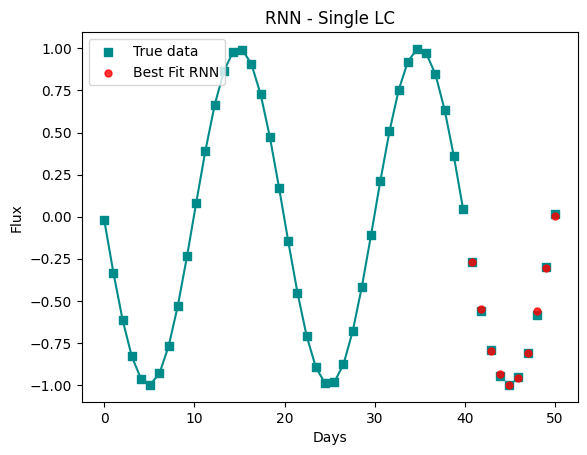

In [18]:
test_image = 2

t_space = np.linspace(0, 50, 50)
plt.plot(t_space[:-n_pred], RNN_X_single[test_image], color ='darkcyan')
plt.scatter(t_space[:-n_pred], RNN_X_single[test_image], color = 'darkcyan', marker='s')
plt.scatter(t_space[-n_pred:], y_test_single[test_image], color = 'darkcyan', marker='s', label = 'True data')
plt.scatter(t_space[-n_pred:], RNN_Y_single[test_image], color = 'red', marker = 'o', s=25, label = 'Best Fit RNN', alpha = 0.8)
plt.title('RNN - Single LC')
plt.xlabel('Days')
plt.ylabel('Flux')
plt.legend(loc = 'upper left')
#plt.savefig('RNN_Single.png', dpi=300)

# Stacked Lightcurve Fitting

There is no substantial differences between single and stacked lightcurve analysis.

#### Gaussian Process

/opt/conda/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Optimized hyper parameters:  4.73**2 * RBF(length_scale=40.6)


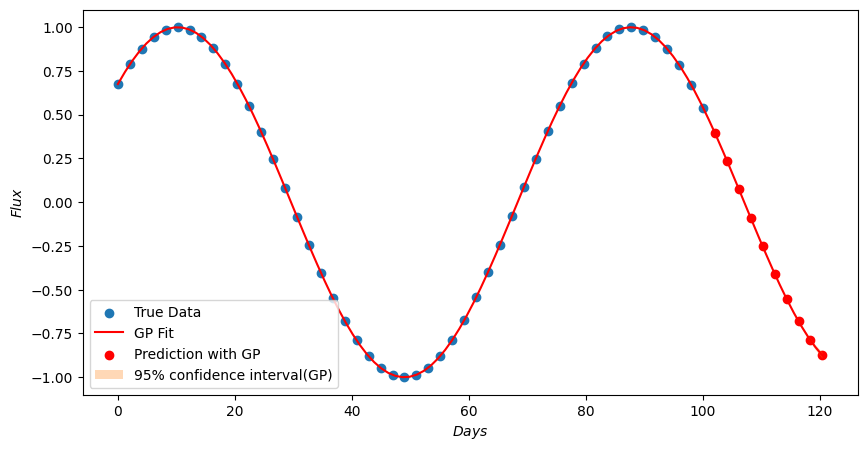

In [19]:
x, y = data_read_image('multiple')
x_true = x
x = x.reshape(-1,1)

n_points = 10

kernel = np.var(y) * k.RBF(length_scale=10.0)


x_pred, y_pred, sigma, optimizedParameters, x_model, y_model, fit_unc = gaussianProcess_fitting(x, y, kernel, n_pred = n_points)
print("Optimized hyper parameters: ", optimizedParameters)


plottingFits(x, y, x_pred, y_pred, x_model.flatten(), y_model.flatten(), sigma, fit_unc)

#### Simple Neural Network

In [20]:
x, y = data_read_full('multiple')

n_pred = 10
y_test_multiple = y[:-n_pred,:].T[0:2000]
y_fit_multiple = y[-n_pred:,:].T[0:2000]

SNN_X_multiple, SNN_Y_multiple, Simple_y_test_multiple = Simple_NN(y_test_multiple, y_fit_multiple)

Epoch 1/200
13/13 [==============================] - 0s 10ms/step - loss: 0.5618 - root_mean_squared_error: 0.7495 - val_loss: 0.4899 - val_root_mean_squared_error: 0.6999 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 0s 3ms/step - loss: 0.4993 - root_mean_squared_error: 0.7066 - val_loss: 0.4594 - val_root_mean_squared_error: 0.6778 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 0s 3ms/step - loss: 0.4664 - root_mean_squared_error: 0.6830 - val_loss: 0.4385 - val_root_mean_squared_error: 0.6622 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 0s 3ms/step - loss: 0.4397 - root_mean_squared_error: 0.6631 - val_loss: 0.4188 - val_root_mean_squared_error: 0.6471 - lr: 0.0010
Epoch 5/200
13/13 [==============================] - 0s 3ms/step - loss: 0.4167 - root_mean_squared_error: 0.6455 - val_loss: 0.4015 - val_root_mean_squared_error: 0.6336 - lr: 0.0010
Epoch 6/200
13/13 [==============================] - 0s 5ms/step - loss: 0.3968

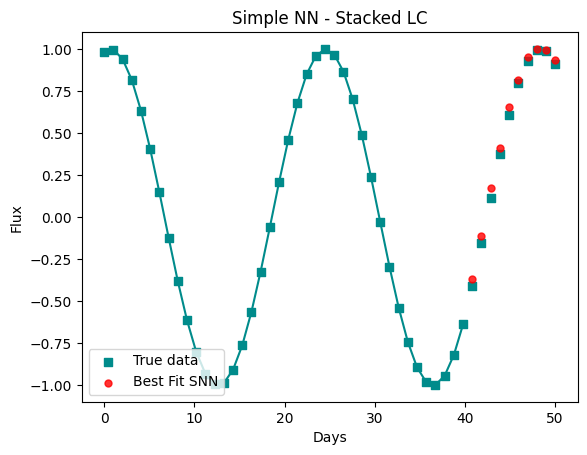

In [21]:
test_image = 2

t_space = np.linspace(0, 50, 50)
plt.plot(t_space[:-n_pred], SNN_X_multiple[test_image], color ='darkcyan')
plt.scatter(t_space[:-n_pred], SNN_X_multiple[test_image], color = 'darkcyan', marker='s')
plt.scatter(t_space[-n_pred:], Simple_y_test_multiple[test_image], color = 'darkcyan', marker='s', label = 'True data')
plt.scatter(t_space[-n_pred:], SNN_Y_multiple[test_image], color = 'red', marker = 'o', s=25, label = 'Best Fit SNN', alpha = 0.8)
plt.title('Simple NN - Stacked LC')
plt.xlabel('Days')
plt.ylabel('Flux')
plt.legend(loc = 'lower left')
#plt.savefig('RNN_Multiple.png', dpi=300)

#### Recurrent Neural Network

In [22]:
x, y = data_read_full('multiple')

n_pred = 10
y_test_multiple = y[:-n_pred,:].T[0:2000]
y_fit_multiple = y[-n_pred:,:].T[0:2000]

RNN_X_multiple, RNN_Y_multiple, y_test_multiple = RNN_fitting(y_test_multiple, y_fit_multiple, n_pred)

(1600, 40)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 40, 32)            3360      
                                                                 
 gru_5 (GRU)                 (None, 40, 16)            2400      
                                                                 
 gru_6 (GRU)                 (None, 40, 16)            1632      
                                                                 
 gru_7 (GRU)                 (None, 14)                1344      
                                                                 
 dense_7 (Dense)             (None, 10)                150       
                                                                 
Total params: 8,886
Trainable params: 8,886
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
13/13 [======================

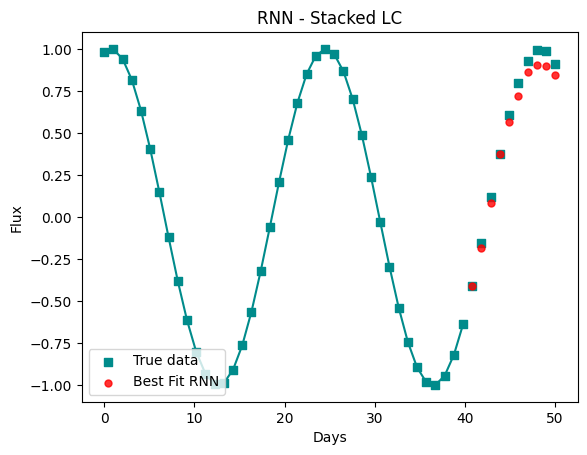

In [23]:
test_image = 2

t_space = np.linspace(0, 50, 50)
plt.plot(t_space[:-n_pred], RNN_X_multiple[test_image], color ='darkcyan')
plt.scatter(t_space[:-n_pred], RNN_X_multiple[test_image], color = 'darkcyan', marker='s')
plt.scatter(t_space[-n_pred:], y_test_multiple[test_image], color = 'darkcyan', marker='s', label = 'True data')
plt.scatter(t_space[-n_pred:], RNN_Y_multiple[test_image], color = 'red', marker = 'o', s=25, label = 'Best Fit RNN', alpha = 0.8)
plt.title('RNN - Stacked LC')
plt.xlabel('Days')
plt.ylabel('Flux')
plt.legend(loc = 'lower left')
#plt.savefig('RNN_Multiple.png', dpi=300)

# Sampled Lightcurves

The sampled lightcurves is where analysis becomes more complicated, due to the need for each neural network to have a consistent number of data points to analyze it. In order to preprocess this data, we choose to perform an interpolation across the data for each individual lightcurve using **scipy.interp1d**, producing a similar lightcurve uniformly sampled and composed of 50 points. We then input this new interpolated lightcurve into each of our networks and perform an analysis of the output.

#### Gaussian Process

/opt/conda/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Optimized hyper parameters:  4.59**2 * RBF(length_scale=40.1)


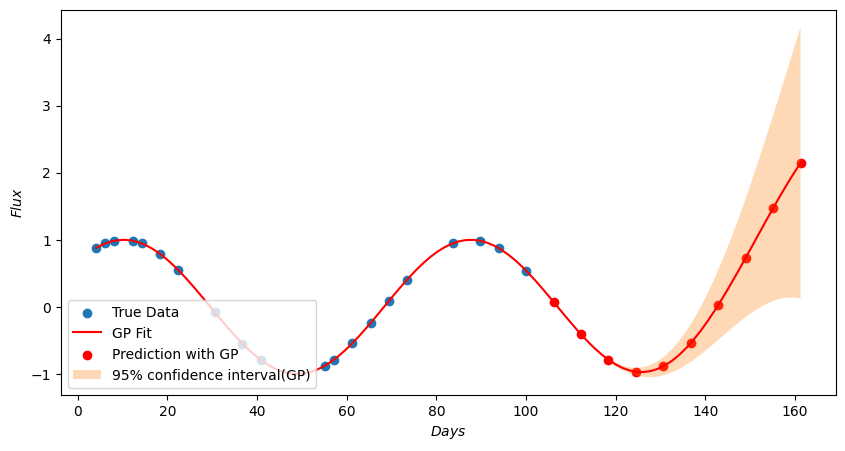

In [24]:
x, y = data_read_image('multiple_sampled')
x_true = x
x = x.reshape(-1,1)
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]
n_points = 10

kernel = np.var(y) * k.RBF(length_scale=10.0)


x_pred, y_pred, sigma, optimizedParameters, x_model, y_model, fit_unc = gaussianProcess_fitting(x, y, kernel, n_pred = n_points)
print("Optimized hyper parameters: ", optimizedParameters)


plottingFits(x, y, x_pred, y_pred, x_model.flatten(), y_model.flatten(), sigma, fit_unc.flatten())

#### Simple Neural Network

In [25]:
x, y = data_read_full('multiple_sampled')

y = sampled_interp(x, y).T
n_pred = 10

y_test_input_MS = y[:-n_pred,:].T[0:2000]
y_fit_MS = y[-n_pred:,:].T[0:2000]

SNN_X_MS, SNN_Y_MS, SNN_y_test_MS = Simple_NN(y_test_input_MS, y_fit_MS)

Epoch 1/200
13/13 [==============================] - 0s 11ms/step - loss: 0.7553 - root_mean_squared_error: 0.8691 - val_loss: 0.6553 - val_root_mean_squared_error: 0.8095 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 0s 4ms/step - loss: 0.6369 - root_mean_squared_error: 0.7980 - val_loss: 0.5711 - val_root_mean_squared_error: 0.7557 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 0s 3ms/step - loss: 0.5723 - root_mean_squared_error: 0.7565 - val_loss: 0.5144 - val_root_mean_squared_error: 0.7172 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 0s 4ms/step - loss: 0.5266 - root_mean_squared_error: 0.7256 - val_loss: 0.4710 - val_root_mean_squared_error: 0.6863 - lr: 0.0010
Epoch 5/200
13/13 [==============================] - 0s 3ms/step - loss: 0.4908 - root_mean_squared_error: 0.7005 - val_loss: 0.4364 - val_root_mean_squared_error: 0.6606 - lr: 0.0010
Epoch 6/200
13/13 [==============================] - 0s 4ms/step - loss: 0.4611

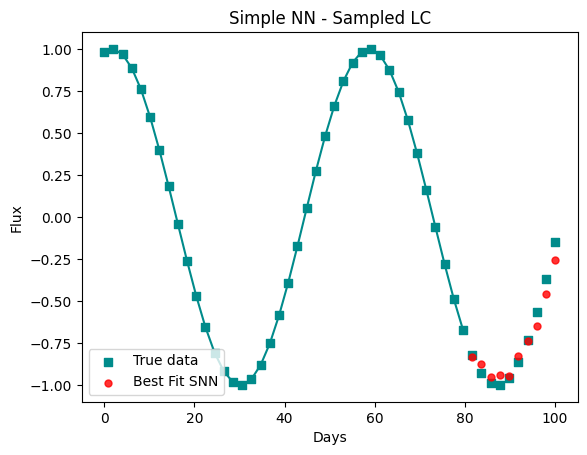

In [26]:
test_image = 2

t_space = np.linspace(0, 100, 50)
plt.plot(t_space[:-n_pred], SNN_X_MS[test_image], color ='darkcyan')
plt.scatter(t_space[:-n_pred], SNN_X_MS[test_image], color = 'darkcyan', marker='s')
plt.scatter(t_space[-n_pred:], SNN_y_test_MS[test_image], color = 'darkcyan', marker='s', label = 'True data')
plt.scatter(t_space[-n_pred:], SNN_Y_MS[test_image], color = 'red', marker = 'o', s=25, label = 'Best Fit SNN', alpha = 0.8)
plt.title('Simple NN - Sampled LC')
plt.xlabel('Days')
plt.ylabel('Flux')
plt.legend(loc = 'lower left')
#plt.savefig('RNN_Sampled.png', dpi=300)

#### Recurrent Neural Network

In [27]:
x, y = data_read_full('multiple_sampled')

y = sampled_interp(x, y).T
n_pred = 10

y_test_input_MS = y[:-n_pred,:].T[0:2000]
y_fit_MS = y[-n_pred:,:].T[0:2000]

RNN_X_MS, RNN_Y_MS, y_test_MS = RNN_fitting(y_test_input_MS, y_fit_MS, n_pred)

(1600, 40)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 40, 32)            3360      
                                                                 
 gru_9 (GRU)                 (None, 40, 16)            2400      
                                                                 
 gru_10 (GRU)                (None, 40, 16)            1632      
                                                                 
 gru_11 (GRU)                (None, 14)                1344      
                                                                 
 dense_11 (Dense)            (None, 10)                150       
                                                                 
Total params: 8,886
Trainable params: 8,886
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
13/13 [======================

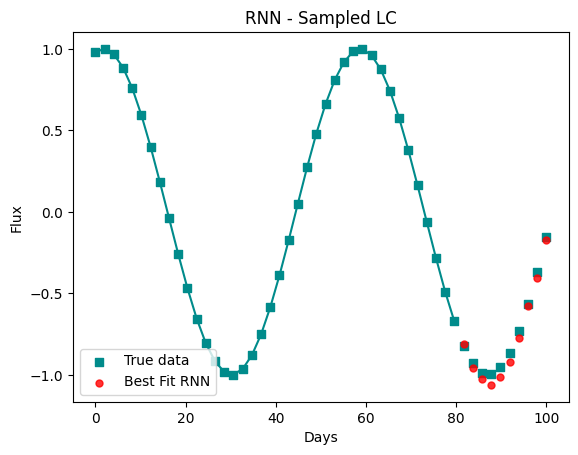

In [28]:
test_image = 2

t_space = np.linspace(0, 100, 50)
plt.plot(t_space[:-n_pred], RNN_X_MS[test_image], color ='darkcyan')
plt.scatter(t_space[:-n_pred], RNN_X_MS[test_image], color = 'darkcyan', marker='s')
plt.scatter(t_space[-n_pred:], y_test_MS[test_image], color = 'darkcyan', marker='s', label = 'True data')
plt.scatter(t_space[-n_pred:], RNN_Y_MS[test_image], color = 'red', marker = 'o', s=25, label = 'Best Fit RNN', alpha = 0.8)
plt.title('RNN - Sampled LC')
plt.xlabel('Days')
plt.ylabel('Flux')
plt.legend(loc = 'lower left')
#plt.savefig('RNN_Sampled.png', dpi=300)

# Plasticc Data

The plasticc data is neither uniformly sampled, nor normalized. Because of this we perform an interpolation (as described above for poorly sampled lightcurves) using scipy.interp1d as well as a normalizing function, **sklearn.preprocessing**. Once interpolated and normalized, we are able to pass our lightcurves into the network and perform an analysis.

The Plasticc dataset contains samples of lightcurves from 13 different periodic source types. In the below models, the lightcurves are fit individually, and then fit using machine learning techniques. As this is true data that is not preprocessed by source type, the fitting algorithm performs much worse than the uniform sources in the previous three datasets.

#### Gaussian Process
This procedure performs a gaussian process fit for a single image in the Plasticc dataset. While this performs relatively well for each of the individual lightcurves, this does not give much infomation for predicting points for future points. This is the simplest method and gives very large uncertainties in areas with limited data.

Optimized hyper parameters:  37.3**2 * RBF(length_scale=7.49)


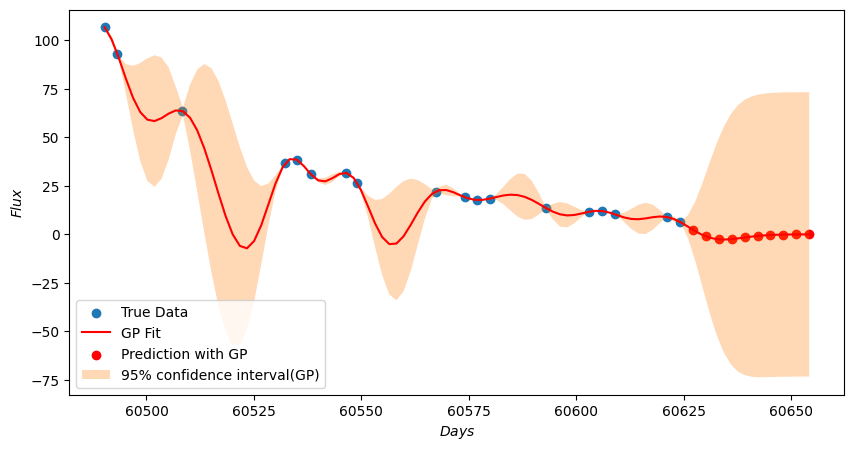

In [29]:
x, y, type_true = data_read_image('plasticc', image_number = 2)
x_true = x
x = x.reshape(-1,1)
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]
n_points = 10

kernel = np.var(y) * k.RBF(length_scale=10.0)


x_pred, y_pred, sigma, optimizedParameters, x_model, y_model, fit_unc = gaussianProcess_fitting(x, y, kernel, n_pred = n_points)
print("Optimized hyper parameters: ", optimizedParameters)


plottingFits(x, y, x_pred, y_pred, x_model.flatten(), y_model.flatten(), sigma, fit_unc)

#### Simple Neural Network
The simple neural network works much better than the GP, due to sampling over all the lightcurves and not individiaul point prediction. There is still substantial room for improvement, as discussed in the RNN.

In [30]:
lc_test, type_true = data_read_full('plasticc_test')
lc_test = np.transpose((lf_processing_Plasticc(lc_test)), (1, 0, 2))

n_pred = 10
lc_test = plasticc_normalizer(lc_test[:,0])

y_cat_NN = (lc_test[:][:, -n_pred:])
lc_x_NN = lc_test[:][:, :-n_pred]

RNN_X_NN, RNN_Y_NN, y_test_NN = Simple_NN(lc_x_NN, y_cat_NN)

100%|██████████| 1135/1135 [00:00<00:00, 34687.41it/s]


Epoch 1/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0616 - root_mean_squared_error: 0.2482 - val_loss: 0.0473 - val_root_mean_squared_error: 0.2174 - lr: 0.0010
Epoch 2/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0429 - root_mean_squared_error: 0.2070 - val_loss: 0.0361 - val_root_mean_squared_error: 0.1899 - lr: 0.0010
Epoch 3/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0338 - root_mean_squared_error: 0.1838 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1704 - lr: 0.0010
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0280 - root_mean_squared_error: 0.1672 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1566 - lr: 0.0010
Epoch 5/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0241 - root_mean_squared_error: 0.1553 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1453 - lr: 0.0010
Epoch 6/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0212 - root_mean

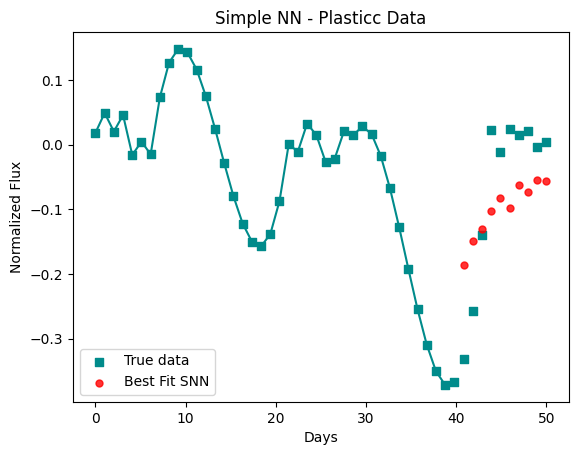

In [31]:
test_image = 60

t_space = np.linspace(0, 50, 50)
test=0
plt.plot(t_space[:-n_pred], RNN_X_NN[test_image], color = 'darkcyan')
plt.scatter(t_space[:-n_pred], RNN_X_NN[test_image], color = 'darkcyan', marker='s')
plt.scatter(t_space[-n_pred:], y_test_NN[test_image], color = 'darkcyan', marker='s', label = 'True data')
plt.scatter(t_space[-n_pred:], RNN_Y_NN[test_image], color = 'red', marker = 'o', s=25, label = 'Best Fit SNN', alpha = 0.8)
plt.title('Simple NN - Plasticc Data')
plt.xlabel('Days')
plt.ylabel('Normalized Flux')
plt.legend(loc = 'lower left')

#### Recurrent Neural Network
The recurrent neural network does not do very well at predicting points for real data sources for the majority of the lightcurves. There are a number of reasons this could be the case, with the most likely being the non-uniformity of the training data. Performing a classification, followed by fitting for each of the lightcurves within the source type would likely produce much better fits.

In [32]:
lc_test, type_true = data_read_full('plasticc_test')
lc_test = np.transpose((lf_processing_Plasticc(lc_test)), (1, 0, 2))

n_pred = 10
lc_test = plasticc_normalizer(lc_test[:,0])

y_cat = (lc_test[:][:, -n_pred:])
lc_x = lc_test[:][:, :-n_pred]

RNN_X, RNN_Y, y_test = RNN_fitting(lc_x, y_cat, n_pred)

100%|██████████| 1135/1135 [00:00<00:00, 5462.07it/s]


(908, 40)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 40, 32)            3360      
                                                                 
 gru_13 (GRU)                (None, 40, 16)            2400      
                                                                 
 gru_14 (GRU)                (None, 40, 16)            1632      
                                                                 
 gru_15 (GRU)                (None, 14)                1344      
                                                                 
 dense_15 (Dense)            (None, 10)                150       
                                                                 
Total params: 8,886
Trainable params: 8,886
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [=========================

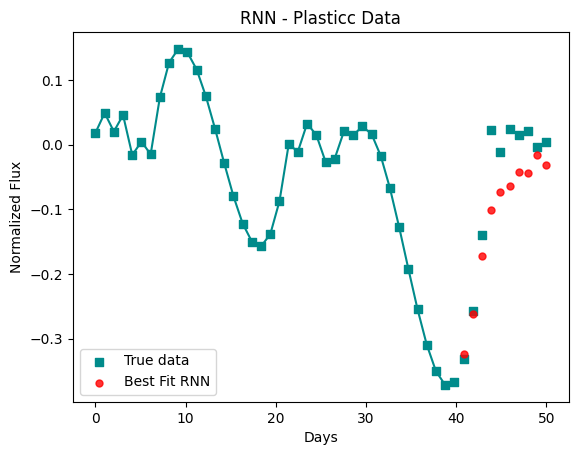

In [33]:
test_image = 60

t_space = np.linspace(0, 50, 50)
test=0
plt.plot(t_space[:-n_pred], RNN_X[test_image], color = 'darkcyan')
plt.scatter(t_space[:-n_pred], RNN_X[test_image], color = 'darkcyan', marker='s')
plt.scatter(t_space[-n_pred:], y_test[test_image], color = 'darkcyan', marker='s', label = 'True data')
plt.scatter(t_space[-n_pred:], RNN_Y[test_image], color = 'red', marker = 'o', s=25, label = 'Best Fit RNN', alpha = 0.8)
plt.title('RNN - Plasticc Data')
plt.xlabel('Days')
plt.ylabel('Normalized Flux')
plt.legend(loc = 'lower left')
#plt.savefig('RNN_Plasticc_61.png', dpi=300)